In [2]:
import torch
from frames.representations import FrameUnembeddingRepresentation, Concept
import matplotlib.pyplot as plt
import cuml
import numpy as np
import seaborn as sns
from frames.utils.ml import run_umap
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

In [3]:
fur = FrameUnembeddingRepresentation.from_model_id(
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
    quantization=4
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-28 14:47:20.819 | INFO     | frames.models.hf.base:__init__:88 - Loaded model: meta-llama/Meta-Llama-3.1-8B-Instruct
2025-03-28 14:47:20.820 | WARNING  | frames.models.hf.base:__init__:89 - memory cost: 5332 Mb


In [4]:
single_token_words = fur.data.get_dataframe(
    fur.model.tokenizer,
    min_lemmas_per_synset=1,
    max_token_count=1,
)["tokens"].list.get(0).unique().values.tolist()

tensor = fur.get_token_representations(single_token_words)

tensor.shape, tensor.device, tensor.dtype

(torch.Size([24538, 4096]), device(type='cuda', index=0), torch.bfloat16)

In [5]:
OPTIONS = {
    "min_lemmas_per_synset": 1,
    "max_token_count": 3,
}

TOKEN = "ism"

df = fur.data.get_dataframe(fur.model.tokenizer, **OPTIONS)

<Axes: xlabel='Word-Concept Correlation', ylabel='Count'>

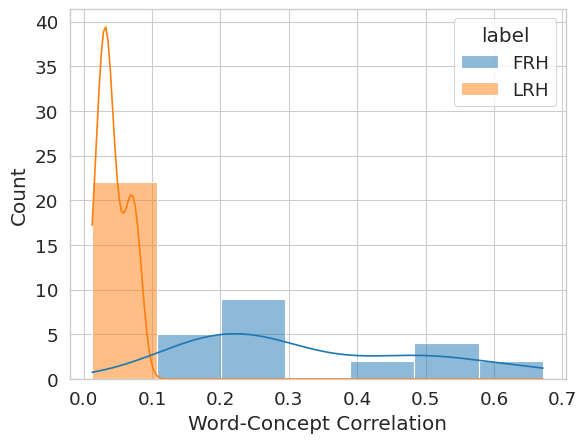

In [ ]:
# concepts = fur.get_all_concepts(**OPTIONS)
# concepts.tensor.shape

ism_token_id = fur.model.tokenizer.encode(TOKEN)[1]
ism_synsets = df[df["tokens"].list.index(ism_token_id) != -1]["synset"].unique()
ism_synsets[~ism_synsets.str.contains("ism")]
# ism_concepts = concepts.tensor[ism_synsets]

# synsets = fur.data.get_all_synsets(fur.model.tokenizer, min_lemmas_per_synset=1, max_token_count=4)

# ism_tokens = np.stack(synsets.loc[synsets["synset"].isin(ism_synsets), "tokens"].values)

# # ism_token_words = df[df["tokens"].list.index(ism_token_id) != -1]["tokens"].unique().to_pandas().tolist()

# ism_tensor = fur.get_token_representations(ism_tokens)

# ism_concepts.shape, ism_concepts.device, ism_concepts.dtype

x = "Word-Concept Correlation"
y = "label"

def compute_synset_inner_correlations(synset):
    i = np.stack(df.loc[df["synset"] == synset, "tokens"].to_pandas().values)
    # w_frh = torch.nn.functional.normalize(fur.get_token_representations(i).mT, p=2, dim=-1)
    w_frh = fur.get_token_representations(i).mT
    w_frh = torch.nn.functional.normalize(w_frh, p=2, dim=-2)

    c_frh = Concept(tensor=fur.average_frames(w_frh), synset=synset)
    c_frh.tensor.unsqueeze_(0)

    frh_proj = (w_frh * c_frh).flatten()

    w_lrh = w_frh.mean(-1, keepdim=True)
    c_lrh = Concept(tensor=w_lrh.mean(0, keepdim=True), synset=synset) 

    lrh_proj = (w_lrh * c_lrh).flatten()

    return pd.DataFrame({
        x: torch.cat([frh_proj, lrh_proj]).cpu().tolist(),
        y: frh_proj.shape[0] * [f"FRH"] + lrh_proj.shape[0] * [f"LRH"],
    })

df_plot = pd.concat([
    compute_synset_inner_correlations(s) for s in ism_synsets[~ism_synsets.str.contains("ism")]
])

sns.histplot(df_plot, x=x, hue=y, kde=True)

In [6]:
df[(df["tokens"].list.index(ism_token_id) != -1) & (df["token count"] == 2)]

,synset,lemma,pos,lang,is top noun,tokens,token count,synset id,lemma id
27757,ableism.n.01,ableism,n,eng,False,"[3025, 2191, 128009]",2,232,60139
27757,ableism.n.01,ableism,n,eng,False,"[481, 2191, 128009]",2,232,376849
27757,ableism.n.01,ablism,n,eng,False,"[98492, 2191, 128009]",2,232,60146
27757,ableism.n.01,ablism,n,eng,False,"[62573, 2191, 128009]",2,232,376856
54458,abolitionism.n.01,abolitionism,n,eng,False,"[76445, 2191, 128009]",2,267,60201
...,...,...,...,...,...,...,...,...,...
25614,voyeurism.n.01,voyeurism,n,eng,False,"[48572, 2191, 128009]",2,105784,309456
55605,wesleyanism.n.01,Wesleyism,n,eng,False,"[58706, 2191, 128009]",2,107000,57834
57840,zionism.n.01,Zionism,n,eng,False,"[41435, 2191, 128009]",2,109332,59353
67958,zionism.n.02,Zionism,n,eng,False,"[41435, 2191, 128009]",2,109333,59353


<Axes: xlabel='Correlation with "ism" concept', ylabel='Count'>

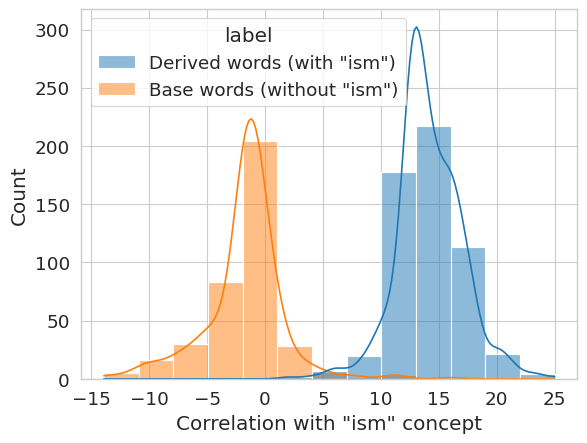

In [7]:
TOKEN = "ism" # ism, ment, ation

ism_token_id = fur.model.tokenizer.encode(TOKEN)[1]

ism_lemmas = df[df["tokens"].list.index(ism_token_id) != -1]["lemma"].str.strip().unique()
ism_negative_lemmas = ism_lemmas.str.replace(TOKEN, "").str.strip().unique()

ism_positive_tokens = df[df["lemma"].isin(ism_lemmas)].drop_duplicates("lemma")["tokens"].to_pandas().values
ism_negative_tokens = df[df["lemma"].isin(ism_negative_lemmas)].drop_duplicates("lemma")["tokens"].to_pandas().values

w_positive = fur.get_token_representations(np.stack(ism_positive_tokens)).mT
w_negative = fur.get_token_representations(np.stack(ism_negative_tokens)).mT

# w_positive = w_positive.mean(dim=-1, keepdim=True)
# w_negative = w_negative.mean(dim=-1, keepdim=True)

c_positive = Concept(tensor=fur.average_frames(w_positive), synset="derived words")
c_negative = Concept(tensor=fur.average_frames(w_negative), synset="base words")

# the idea of "ism" can be isolated as the average of all words with ism - their counterparts without ism
# only the combined concept is able to gracefully isolate the two groups.
c = c_positive - c_negative
c.tensor.unsqueeze_(0)

x = f"Correlation with \"{TOKEN}\" concept"
y = "label"

df_plot = pd.DataFrame({
    x: torch.cat([w_positive * c, w_negative * c]).flatten().cpu().tolist(),
    y: w_positive.shape[0] * [f"Derived words (with \"{TOKEN}\")"] + w_negative.shape[0] * [f"Base words (without \"{TOKEN}\")"],
})

sns.histplot(df_plot, x=x, hue=y, kde=True)

# df[df["lemma"].isin(negative_lemmas)].drop_duplicates("lemma")

In [26]:
w_positive.shape

torch.Size([562, 4096, 3])